# Regularização

Bem-vindo a segunda tarefa desta semana. Modelos de aprendizado profundo possuem muita flexibilidade e capacidade, porém, **overfitting** pode ser um problema sério se o conjunto de treinamento não for grande o bastante. A rede pode aprender bem no conjunto de treinamento mas ela **não generaliza** para exemplos que ela nunca viu! 

Nesta tarefa você irá aprender a utilizar regularização em seus modelos de aprendizado profundo. 

Vamos primeiro importar os pacotes necessários para esta tarefa.

In [1]:
# pacotes importantes
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_fsf_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # define o tamanho padrão dos gráficos.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


**Definição do Problema**: Você acabou de ser contratado como um especialista em IA pela Federação Francesa de Futebol. Eles querem que você recomende posições onde o goleiro da equipe francesa deva chutar a bola de forma que os jogadores do time frances possam dominá-la.  

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figura 1** </u>: **Campo de Futebol**<br> O goleiro chuta a bola no ar, os jogadores de cada equipe lutam para dominar a bola </center></caption>


A FFF forneceu a você a seguinte base de dados dos últimos 10 jogos da França. 

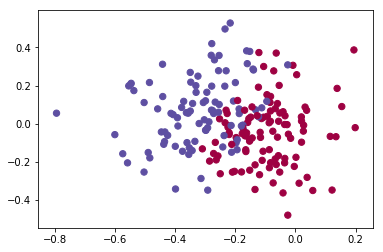

In [2]:
train_X, train_Y, test_X, test_Y = load_fsf_dataset()

Cada ponto corresponde a uma posição no campo de futebol onde a bola foi dominada após o chute do goleiro da França estando defendendo o goldo lado esquerdo do campo. 
- Um ponto azul quer dizer que o time da França dominou a bola após o chute do goleiro.
- Um ponto vermelho indica que a bola foi dominada pelo time adversário.

**Seu objetivo**: Utilizar aprendizado profundo para encontrar as posições no campo onde o goleiro deveria chutar a bola. 

**Analise dos dados**: Esta base de dados é um pouco ruidosa, porém, parece que encontrar uma linha diagonal separando a metade superior esquerda do campo (pontos azuis) da parte inferior direita (pontos vermelhos) deve ser o suficiente. 

Você irá primeiro tentar um modelo sem utilizar regularização. Em seguida você irá aprender a aplicar regularização e decidir qual o modelo melhor para o problema da FFF. 

## 1 - Modelo não regularizado

Você irá utilizar uma rede neural já implementada para você. Este modelo pode ser utilizado: 
- no *regularization mode* -- ajustando o valor de `lambd` para um valor diferente de zero. Usamos "`lambd`" no lugar de "`lambda`" porque "`lambda`" é uma palavra reservada em Python. 
- no *dropout mode* -- ajustando o valor de `keep_prob` para um valor menor que 1.

Primeiro vamos tentar um modelo sem regularização. Em seguida você irá implementar:
- *Regularização L2* -- com as funções: "`compute_cost_with_regularization()`" e "`backward_propagation_with_regularization()`"
- *Dropout* -- com as funções: "`forward_propagation_with_dropout()`" e "`backward_propagation_with_dropout()`"

Em cada parte, você executará este modelo com as entradas corretas de forma que ele chame as funções que você implementou. Verifique o código abaixo para se familiarizar com o modelo. 

In [3]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implementa uma rede neural com 3 camadas: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Argumentos:
    X -- dados de entrada, no formato (tamanho da entrada, número de exemplos)
    Y -- vetor com valores corretos da saída (1 para azul/0 para vermelho), no formato (tamanho saída, número de exemplos)
    learning_rate -- taxa de aprendizado da otimização.
    num_iterations -- número de interações do loop de otimização.
    print_cost -- Se True, imprime o valor da função de custo a cada 10.000 interações.
    lambd -- hiper parâmetro de regularização, valor escalar.
    keep_prob - probabilidade de se manter um neurônio durante a execução do dropout, valor escalar.
    
    Retorna:
    parameters -- os parâmetros aprendidos pelo modelo. Ele pode ser utilizado para prever novas saídas.
    """
        
    grads = {}
    costs = []                            # armazena os valores do custo
    m = X.shape[1]                        # número de exemplos
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Inicializa o dicionário de parâmetros.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradiente descendente)

    for i in range(0, num_iterations):

        # Propagação para frente: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Função de custo
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Propagação para trás.
        assert(lambd==0 or keep_prob==1)    # é possível utilizar tanto a regularização L2 como o dropout, 
                                            # mas nesta tarefa iremos explorar um de cada vez.
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Atualiza Parâmetros.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Imprime a perda a cada 10.000 interações
        if print_cost and i % 10000 == 0:
            print("Custo após a interação {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('custo')
    plt.xlabel('interações (x 1.000)')
    plt.title("Taxa de aprendizado =" + str(learning_rate))
    plt.show()
    
    return parameters

Vamos treinar o modelo sem o uso de regularização e observar a acurácia nos conjuntos de treinamento e de teste. 

Custo após a interação 0: 0.6782273492526809
Custo após a interação 10000: 0.24799189757336793
Custo após a interação 20000: 0.255067733057058


/home/bruno/Documentos/Mackenzie/Deep Learning/deep_learning/atividade_05_02/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/bruno/Documentos/Mackenzie/Deep Learning/deep_learning/atividade_05_02/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


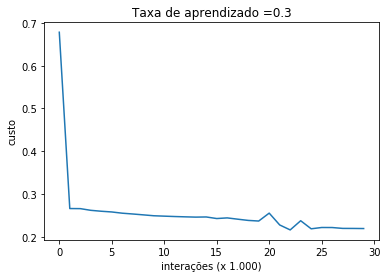

No conjunto de treinamento:
Accuracy: 0.875
No conjunto de teste:
Accuracy: 0.84


In [4]:
parameters = model(train_X, train_Y)
print ("No conjunto de treinamento:")
predictions_train = predict(train_X, train_Y, parameters)
print ("No conjunto de teste:")
predictions_test = predict(test_X, test_Y, parameters)

Não se preocupe com o erro de aproximação apresentado. Note que a acurácia no conjunto de treinamento é de 87,5% enquanto que a acurácia no conjunto de teste é de 84%. Este éo nosso **modelo básico**. Vamos ver o efeito do uso de regularização neste modelo. Execute a célula abaixo para plotar a linha de decisão encontrada por este modelo. 

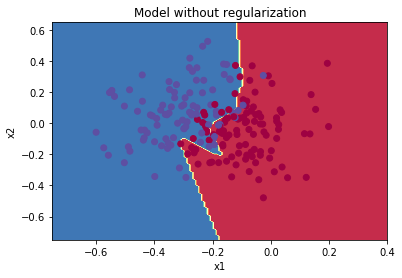

In [6]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

O modelo sem regularização parece estar super ajustado aos dados de treinamento. Ele está se ajustando a pontos com ruído. Vamos ver o que acontece quando utilizamos reguralização para reduzir super ajuste "overfitting". 

## 2 - Regularização L2

A forma padrão de se evitar o super ajuste é chamada de **Regularização L2**. ela consiste em modificar de forma apropriada a função de custo, do: 
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
Para:
$$J_{regularizado} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{custo de entropia cruzada} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{Custo da regularização L2} \tag{2}$$

Vamos modificar o custo e observar as consequencias.

**Exercício**: Implemente `compute_cost_with_regularization()` que computa o custo dado pela fórmula (2). Para calcular $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , use :
```python
np.sum(np.square(Wl))
```
Note que você deve fazer isto para $W^{[1]}$, $W^{[2]}$ e $W^{[3]}$, então some os três termos e multiplique por $ \frac{1}{m} \frac{\lambda}{2} $.

In [36]:
# FUNÇÃO DE AVALIAÇÃO: compute_cost_with_regularization

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implemente a função de custocom regularização L2. Veja a fórmula (2) acima.
    
    Argumentos:
    A3 -- pós-ativação, saída da propagação para frente, no formato (tamanho da saída, número de exemplos)
    Y -- vetor com saídas corretas, no formato (tamanho da saída, número de exemplos)
    parameters -- dicionário python contendo os parâmetros do modelo.
    
    Retorna:
    cost - valor da função de custo regularizada (fórmula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    cross_entropy_cost = compute_cost(A3, Y) # Isto dá a você a parte da entropia cruzada do custo.
    
    ### INICIE O SEU CÓDIGO AQUI ### (aprox. 1 linha)
    
    L2_regularization_cost = (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) * (1/m) * lambd/2
    ### TÉRMINO DO CÓDIGO ###
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [37]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("custo = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

custo = 1.7864859451590758


**Saída esperada**: 

<table> 
    <tr>
    <td>
    **cost**
    </td>
        <td>
    1.78648594516
    </td>
    
    </tr>

</table> 

Claro que, como você alteru a função de custo, você deve também modificar a propagação para trás! Todos os gradientes devem ser computados com relação a este novo custo. 

**Exercício**: Implemente as mudanças necessárias na propagação para trás de forma a considerar o efeito de regularização. As mudanças dizem respeito apenas a dW1, dW2 e dW3. Para cada um, você deve adicionar o termo do gradiente da regularização  ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [54]:
# FUNÇÃO DE AVALIAÇÃO: backward_propagation_with_regularization

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implementa a propagação para trás do modelo básicoonde foi adicionada regularização L2.
    
    Argumentos:
    X -- dados de entrada, no formato (tamanho da entrada, número de exemplos)
    Y -- vetor com valores corretos de saída, no formato (tamanho da saída, número de exemplos)
    cache -- cache com a saída da propagação para frente
    lambd -- hiper parâmetro de regularização, valor escalar
    
    Retorna:
    gradients -- Um dicionário com os gradientes com relação a cada parâmetro, variáveis de ativação e pré-ativação
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    ### INICIE O SEU CÓDIGO AQUI ### (aprox. 1 linha)
    dW3 = (1 / m) * np.dot(dZ3, A2.T) + (lambd/m*W3)
    ### TÉRMINO DO CÓDIGO ###
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    ### INICIE O SEU CÓDIGO AQUI ### (aprox. 1 linha)
    dW2 = (1 / m) * np.dot(dZ2, A1.T) + lambd/m*W2
    ### TÉRMINO DO CÓDIGO ###
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    ### INICIE O SEU CÓDIGO AQUI ### (aprox. 1 linha)
    dW1 = (1 / m) * np.dot(dZ1, X.T) + lambd/m*W1
    ### TÉRMINO DO CÓDIGO ###
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [55]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


**Saída esperada**:

<table> 
    <tr>
    <td>
    **dW1**
    </td>
        <td>
    [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
    </td>
    </tr>
    <tr>
    <td>
    **dW2**
    </td>
        <td>
    [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
    </td>
    </tr>
    <tr>
    <td>
    **dW3**
    </td>
        <td>
    [[-1.77691347 -0.11832879 -0.09397446]]
    </td>
    </tr>
</table> 

Vamos agora executar o modelo utilizando a regularização L2 $(\lambda = 0.7)$. A função `model()` irá chamar: 
- `compute_cost_with_regularization` no lugar de `compute_cost`
- `backward_propagation_with_regularization` no lugar de `backward_propagation`

Custo após a interação 0: 0.7222284420507836
Custo após a interação 10000: 0.3164512112821656
Custo após a interação 20000: 0.3163507125244206


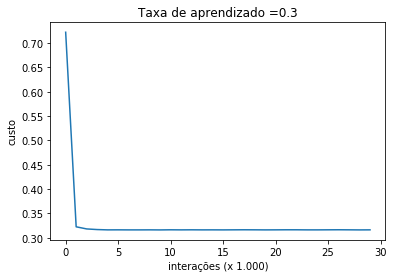

No conjunto de treinamento:
Accuracy: 0.865
No conjunto de teste:
Accuracy: 0.82


In [56]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("No conjunto de treinamento:")
predictions_train = predict(train_X, train_Y, parameters)
print ("No conjunto de teste:")
predictions_test = predict(test_X, test_Y, parameters)

As acurácias não variaram muito embora tenham diminuído um pouco, porém, não deve ter ocorrido um super ajuste aos dados de treinamento. Vamos plotar  o linha de decisão do dados de treinamento.

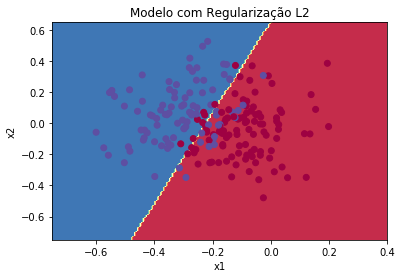

In [57]:
plt.title("Modelo com Regularização L2")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observações**:
- O valor de $\lambda$ é um hiper parâmetro que você pode ajustar utilizando um conjunto de desenvolvimento. Se $\lambda$ é muito grande, é possível obter um modelo com bias alto.
- A regularização L2 determina uma lnha clara de separação dos dados o que deve facilitar a vida do goleiro da França, se compararmos com o que foi dado pelo modelo básico.  

**O que a regularização L2 está realmente fazendo?**:

A regularização L2 assume que o modelo com pesos pequenos é mais simples que o modelo com pesos altos. Portanto, por penalizar o quadrado dos valores dos pesos na função de custo faz com que os pesos tenham valores pequenos. O custo compesos altos fica alto também. Isto faz com que o modelo seja mais suave e as saídas mudam mais lentamente.   

<font color='blue'>
**O que você deve lembrar** -- A implicação da regularização L2:
- A computação do custo:
    - Um termo de regularização é adicionado ao custo.
- A função de propagação para trás:
    - Existem termos extras nos gradientes com relação as matrizes de peso.
- Pesos acabam ficando menores ("weight decay"): 
    - Os pesos são encaminhados para valores menores.

## 3 - Dropout

Finalmente, **dropout** é muito utilizado como técnica de regularização específica de aprendizado profundo. 
**Ela aleatoriamente desliga alguns neurônios em cada interação.** Assita a estes dois videos para ver o que isto quer dizer!

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more features my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 


<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Figura 2 </u>: Dropout na segunda camada escondida. <br> Em cada interação você desliga (= define como zero) cada neurônio de uma camada com probabilidade $1 - keep\_prob$ ou mantém o neurônio com probabilidade $keep\_prob$ (50% aqui). Os neurônios desligados não contribuem para o treinamento tanto na propagação para frente como na propagação para trás da interação considerada. </center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> Figura 3 </u>: Dropout da primeira e da terceira camada escondida. <br> $1^{a}$ camada: nós desligamos na média 40% dos neurônios.  $3^{a}$ camada: nós desligamos na média 20% dos neurônios. </center></caption>


Quando você desliga alguns neurônios, você modifica o seu modelo. A idéia por trás de dropout é que em cada interação você treina um modelo diferente que utiliza apenas um sub conjunto dos neurônios do modelo. Com dropout os neurônios se tornam menos sensitivos para a ativação de um outro neurônio específico, porque aquele neurônio pode ser desligado a qualquer instante.  

### 3.1 - Propagação para frente com dropout

**Exercício**: Implemente a propagação para frente com dropout. Você está utilizando uma rede com 3 camadas e irá adicionar dropout apenas para a primeira e a segunda camadas escondidas. Não será utilizado o dropout para as camadas de entrada e de saída.    

**Instruções**:
Você deseja desligar alguns neurônios na primeira e segunda camadas escondidas. Você deve executar as 4 seguintes etapas:
1. Nós falamos em criar uma variável $d^{[1]}$ com o mesmo formato de $a^{[1]}$ usando `np.random.rand()` para aleatoriamente gerar números entre 0 e 1. Aqui, você irá utilizar uma implementação vetorizada, portanto, crie uma matriz aleatória $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ da mesma dimensão que $A^{[1]}$.
2. Defina cada entrada de $D^{[1]}$ para 0 com probabilidade (`1-keep_prob`) ou 1 com probabilidade (`keep_prob`), fazendo um corte nos valores de $D^{[1]}$ apropriadamente. Dica: para definir todas as entradas de uma matriz X para 0 (se a entrada é menor que 0,5) ou 1 (se a entrada é maior que 0,5) você pode fazer: `X = (X < 0.5)`. Note que 0 e 1 são respectivamente equivalentes a Falso e Verdadeiro.
3. Ajuste $A^{[1]}$ para $A^{[1]} * D^{[1]}$. (Você está desligando alguns neurônios). Você pode considerar $D^{[1]}$ como uma máscara, de forma que quando ela é multiplicada por outra matriz, ela desliga alguns de seus valores.
4. Divida $A^{[1]}$ por `keep_prob`. Fazendo isto você está assegurando que o rsultado do custo continuará com o mesmo valor esperado se não houvesse o dropout. (Esta técnica é conhecida como dropout invertido). 

In [81]:
# FUNÇÃO DE AVALIAÇÃO: forward_propagation_with_dropout

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implementa a propagação para frente: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Argumentos:
    X -- dados de entrada, no formato (2, número de exemplos)
    parameters -- dicionário python contendo os parâmetros "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- matriz de pesos no formato (20, 2)
                    b1 -- vetor bias no formato (20, 1)
                    W2 -- matriz de pesos no formato (3, 20)
                    b2 -- vetor bias no formato (3, 1)
                    W3 -- matriz de pesos no formato (1, 3)
                    b3 -- vetor bias no formato (1, 1)
    keep_prob - probabilidade de manter o neurônioativo durante o dropout, um valor escalar
    
    Retorna:
    A3 -- último valor de ativação, saída da propagação para frente, no formato (1,1)
    cache -- tuple, informação armazenada para computação da propagação para trás.
    """
    
    np.random.seed(1)
    
    # recupera os parâmetros
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)

    ### INICIE O SEU CÓDIGO AQUI ### (aprox. 4 linhas)       # Steps 1-4 abaixo correspondem as etapas descritas acima. 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])# Step 1: initializa a matriz D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob)# Step 2: converte as entradas de D1 para 0 ou 1 (usando keep_prob como valor de corte)
    A1 =  A1 * D1 # Step 3: desliga alguns neurônios de A1
    A1 = A1 / keep_prob # Step 4: escala o valor dos neurônios que não foram desligados
    ### TERMINA O CÓDIGO AQUI ###
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    ### INICIE O SEU CÓDIGO AQUI ### (aprox. 4 linhas)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])# Step 1: inicializa a matriz D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob)# Step 2: converte as entradas de D2 para 0 ou 1 (usando keep_prob como valor de corte)
    A2 = A2 * D2 # Step 3: desliga alguns neurônios de A2
    A2 = A2 / keep_prob# Step 4: escala o valor dos neurônios que não foram desligados
    ### TERMINA O CÓDIGO AQUI ###
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [82]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


**Saída esperada**: 

<table> 
    <tr>
    <td>
    **A3**
    </td>
        <td>
    [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]
    </td>
    
    </tr>

</table> 

### 3.2 - Propagação para trás com dropout

**Exercício**: Implemene a propagação para trás com dropout. Como antes, você está treinando uma rede com 3 camadas. Adicione dropout para a primeira e segunda camadas escondidas utilizando as máscaras $D^{[1]}$ e $D^{[2]}$ armazenadas na cache. 

**Instruções**:
Propagação para trás com dropout é bem simples. Você deve seguir as 2 etapas abaixo: 
1. Você desligou previamente alguns neurônios durante a propagação para frente aplicando a máscara $D^{[1]}$ para `A1`. Na propagação para trás você deve desligar os mesmos neurônios utilizando a mesma máscara $D^{[1]}$ para `dA1`. 
2. Durante a propagação para frente voc6e dividiu `A1` por `keep_prob`. Na propagação para trás, você deverá também dividir`dA1` por `keep_prob` (a interpretação do cálculo é que se $A^{[1]}$ é escalonado por `keep_prob`, então a sua derivada $dA^{[1]}$ também deve ser escalonada pelo mesmo `keep_prob`).


In [95]:
# FUNÇÃO DE AVALIAÇÃO: backward_propagation_with_dropout

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implementa a propagação para trás do modelo básico quando adicionado dropout.
    
    Argumentos:
    X -- dados de entrada, no formato (2, número de exemplos)
    Y -- vetor de saída com os valores corretos, no formato (tamanho de saída, número de exemplos)
    cache -- cache de saída da função forward_propagation_with_dropout()
    keep_prob - probabilidade de manter um neurônio ativo durante o dropout, valor escalar.
    
    Retorna:
    gradients -- Um dicionário com os gradientes relacionados a cada parâmetro, variáveis de ativação e pré-ativação.
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
    dA2 = D2 * dA2       # Step 1: Aplique a máscara D2 para desligar os mesmos neurônios da propagação para frente
    dA2 = dA2 / keep_prob       # Step 2: escale o valor dos neurônios que não foram desligados
    ### TERMINE O CÓDIGO AQUI ###
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
    dA1 = D1 * dA1       # Step 1: Aplique a máscara D1 para desligar os mesmos neurônios da propagação para frente
    dA1 = dA1 / keep_prob    # Step 2: escale o valor dos neurônios que não foram desligados
    ### TERMINE O CÓDIGO AQUI ###
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [96]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


**Saída esperada**: 

<table> 
    <tr>
    <td>
    **dA1**
    </td>
        <td>
    [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
    </td>
    
    </tr>
    <tr>
    <td>
    **dA2**
    </td>
        <td>
    [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]
    </td>
    
    </tr>
</table> 

Vamos agora executar o modelo com dropout (`keep_prob = 0.86`). Isto quer dizer que a cada interação serão desligados neurônios das camadas escondidas 1 e 2 com 14% de probabilidade. A função `model()` irá chamar:
- `forward_propagation_with_dropout` no lugar de `forward_propagation`.
- `backward_propagation_with_dropout` no lugar de `backward_propagation`.

Custo após a interação 0: 0.6766024155043613


/home/bruno/Documentos/Mackenzie/Deep Learning/deep_learning/atividade_05_02/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/bruno/Documentos/Mackenzie/Deep Learning/deep_learning/atividade_05_02/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Custo após a interação 10000: 0.12869929410390096
Custo após a interação 20000: 0.12746802184493597


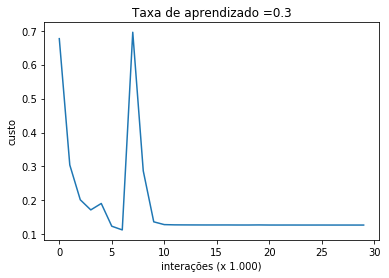

No conjunto de treinamento:
Accuracy: 0.87
No conjunto de teste:
Accuracy: 0.82


In [97]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("No conjunto de treinamento:")
predictions_train = predict(train_X, train_Y, parameters)
print ("No conjunto de teste:")
predictions_test = predict(test_X, test_Y, parameters)

Não se preocupe com o erro de execução, ele ocorre, conforme já falado, devido a aproximações do python.

Dropout funcionou bem! A acurácia permaneceu em 82% para o conjunto de teste e 87,5% para o conjunto de treinamento e a área definida no campo não está super ajustada como no caso do modelo básico. O time da França será eternamente grato a você!!! 

Execute o código abaixo para ver a função limite.

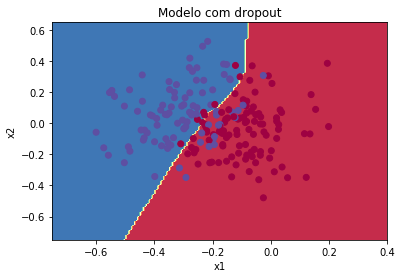

In [98]:
plt.title("Modelo com dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Nota**:
- Um **erro comum** quando utilizamos dropout é utilizá-lo nos conjuntos de treinamento e de teste. O dropout deve ser utilizado apenas no treinamento e desligado no teste.  
- Frameworks de aprendizado profundo como [tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [keras](https://keras.io/layers/core/#dropout) ou [caffe](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) vem com uma implementação de camada de dropout. Não se preocupe - iremos estudar alguns destes frameworks mais a frente.  

<font color='blue'>
**O que você deve se lembrar sobre dropout:**
- Dropout é uma técnica de regularização.
- Você deve utilizar dropout apenas no treinamento e nunca no teste.
- Dropout deve ser aplicado nas propagações para frente e para trás.
- Durante o treinamento, divida a saída de cada camada que utiliza dropout por keep_prob para manter o mesmo valor esperado de ativação. Por exemplo, se keep_prob é 0.5, então, na média, desligue metade dos nós e a saída deve ser escalonada por 0,5 pois somente metade dos nós estão contribuindo para a solução. Dividindo por 0,5 é o equivalente a multiplicar por 2. Logo, a saída agora terá o mesmo valor esperado. Você pode verificar que isto funciona,mesmo que keep_prob tenha outros valores. 

## 4 - Conclusões

**Aqui estão os resltados dos três modelos**: 

<table> 
    <tr>
        <td>
        **modelo**
        </td>
        <td>
        **acurácia treinamento**
        </td>
        <td>
        **acurácia teste**
        </td>

    </tr>
        <td>
        RN com 3-camadas sem regularização
        </td>
        <td>
        87,5%
        </td>
        <td>
        84%
        </td>
    <tr>
        <td>
        RN com 3-camadas e usando regularização L2
        </td>
        <td>
        86,5%
        </td>
        <td>
        82%
        </td>
    </tr>
    <tr>
        <td>
        RN com 3-camadas usando dropout
        </td>
        <td>
        87,5%
        </td>
        <td>
        82%
        </td>
    </tr>
</table> 

Note que a regularização penaliza o desempenho no conjunto de teste. Isto ocorre porque ela limita a habilidade da rede de super ajustar aos dados de treinamento. Mas ela acaba fornecendo um modelo mais simples e com resultados semelhantes.  

Parabéns, você concluiu esta tarefa!!

<font color='blue'>
**O que você deve lembrar desta tarefa**:
- Regularização ajuda a evitar o super ajuste.
- Regularização irá levar os pesos para valores mais baixos.
- Regularização L2 e Dropout são duas técnicas efetivas de regularização.